In [5]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import train_test_split.
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Import logistic regression and pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# importing scaler 
from sklearn.preprocessing import StandardScaler

# import vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#import metrics 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import nltk
from nltk.stem import WordNetLemmatizer

In [6]:
# top imports from Emmanuel 

import keras
import nltk
import re
import codecs

In [7]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/projects/project_3/practice_code'

In [8]:
stoic_zen = pd.read_csv('../datasets/stoic_zen.csv')

In [9]:
stoic_zen.head()

,label,merged
0,0,You need to fight your mind every time it trie...
1,0,A phone call creates stronger bonds than text-...
2,0,"Everything in your life every experience, ever..."
3,0,The Parable of the Mexican Fisherman got me re...
4,0,The key to success and productivity isn’t to t...


In [10]:
stoic_zen.tail()

,label,merged
5990,1,Stoicism and Self-improvement I have just rece...
5991,1,Should I go cold turkey on entertainment to pr...
5992,1,"Free Law of Attraction, The Secret PDF and Boo..."
5993,1,Anxiety I have trouble rationalising with my a...
5994,1,"""Some poor, phoneless fool is probably sitting..."


In [11]:
stoic_zen.isnull().sum()

label     0
merged    0
dtype: int64

In [12]:
stoic_zen['merged'][0]

'You need to fight your mind every time it tries to convince you that you are: not good enough, criticized, too serious, not interesting, not wanted, excluded, rejected, or laughed at. Martin Brown '

In [13]:
type(stoic_zen['merged'][0])

str

_**CITATION:**_ 

For this Logistic Regression exploration, I have drawn huge insights and inspiration from this [NLP workshop by Emmanuel Ameisen (@EmmanuelAmeisen), from Insight AI](https://github.com/EmFib/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb). 

I have implemented his code in several places and cite it there with the shorthand reference _"Emmanuel"_. 

In [14]:
# This method for cleaning data from Emmanuel 

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

stoic_zen = standardize_text(stoic_zen, 'merged')

In [15]:
pwd

'/Users/emilynaftalin/Data_Science/General Assembly/dsi/projects/project_3/practice_code'

In [16]:
# reading my cleaned dataset to a file for future use 

stoic_zen.to_csv('../datasets/clean_stoic_zen.csv', index=False)

In [17]:
# logistic regression needs me to remove URLs

# import re

# for text in stoic_zen['merged']: 
#     text = re.sub(r'http\S+', '', text)

In [18]:
# stoic_zen['merged'] = stoic_zen['merged'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [19]:
X = stoic_zen['merged']
y = stoic_zen['label']

In [20]:
# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size=0.33,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

In [21]:
# instantiating a logistic regression model 

logreg = LogisticRegression()

In [22]:
# logreg.fit(X_train, y_train)

The above method for fitting a Logisit Regression model on my X and y train seems to not have worked. Even after having cleaned my `merged` column using the `standardize_text` function, it throws a `ValueError` related to certain lines, e.g.: 

```
ValueError: could not convert string to float: 'a great song with a stoic theme     '
```

Next, I will try instead to implement a Logisitc Regression after converting my dataset using `Bag of Words` and will also do other preprocessing to investigate whether that will yield a successful result. 

## Data Inspection and Pre-Processing 

In [23]:
stoic_zen.iloc[3010]

label                                                     1
merged    stoicism in the lord of the rings   part 1   c...
Name: 3010, dtype: object

In [24]:
stoic_zen.head()

,label,merged
0,0,you need to fight your mind every time it trie...
1,0,a phone call creates stronger bonds than text ...
2,0,"everything in your life every experience, ever..."
3,0,the parable of the mexican fisherman got me re...
4,0,the key to success and productivity isn t to t...


In [25]:
stoic_zen[2990:3010]

,label,merged
2990,0,as a teen he was making more money than his te...
2991,0,the reason for developing healthy habits del...
2992,0,sounds and musical instruments for meditation ...
2993,0,the stoic inner citadel
2994,0,think what was your mental reaction to the tit...
2995,0,the power of silence refreshing your brain
2996,0,how changing your outlook can make a huge diff...
2997,1,can an emotional person practice stoic philoso...
2998,1,i ve recently been wanting to get into stoicis...
2999,1,if you feeling that you stuck in your practice...


In [26]:
# looking at class balance again 

stoic_zen.groupby('label').count()

,merged
label,
0,2997
1,2998


Our classes are nice and balanced! 

In [27]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [28]:
# tokenizing sentence to list of separate words 

stoic_zen['tokens'] = stoic_zen['merged'].apply(tokenizer.tokenize)
stoic_zen.head()

,label,merged,tokens
0,0,you need to fight your mind every time it trie...,"[you, need, to, fight, your, mind, every, time..."
1,0,a phone call creates stronger bonds than text ...,"[a, phone, call, creates, stronger, bonds, tha..."
2,0,"everything in your life every experience, ever...","[everything, in, your, life, every, experience..."
3,0,the parable of the mexican fisherman got me re...,"[the, parable, of, the, mexican, fisherman, go..."
4,0,the key to success and productivity isn t to t...,"[the, key, to, success, and, productivity, isn..."


In [29]:
pd.options.display.max_colwidth

50

In [30]:
pd.options.display.max_colwidth = 100

In [31]:
stoic_zen.head()

,label,merged,tokens
0,0,"you need to fight your mind every time it tries to convince you that you are not good enough, c...","[you, need, to, fight, your, mind, every, time, it, tries, to, convince, you, that, you, are, no..."
1,0,a phone call creates stronger bonds than text based communications people too often choose to s...,"[a, phone, call, creates, stronger, bonds, than, text, based, communications, people, too, often..."
2,0,"everything in your life every experience, every relationship is a mirror of the mental pattern t...","[everything, in, your, life, every, experience, every, relationship, is, a, mirror, of, the, men..."
3,0,the parable of the mexican fisherman got me reevaluating what it means to live my best life,"[the, parable, of, the, mexican, fisherman, got, me, reevaluating, what, it, means, to, live, my..."
4,0,"the key to success and productivity isn t to try to maximize every single minute in the day, but...","[the, key, to, success, and, productivity, isn, t, to, try, to, maximize, every, single, minute,..."


#### Inspecting distribution of post length 

In [32]:
# code inspired by Emmanuel 
all_words = [word for tokens in stoic_zen['tokens'] for word in tokens]    # getting all the words in the posts
post_lengths = [len(tokens) for tokens in stoic_zen['tokens']]    # getting length of the all the posts
vocab = sorted(list(set(all_words)))    # getting the list of unique words in the corpus composed of the subreddit posts
print(f'{len(all_words)} words total, with a vocabulary size of {len(vocab)}')
print(f'Max post length is {max(post_lengths)} words')
print(f'Average post length is {np.mean(post_lengths).round(2)} words')

472924 words total, with a vocabulary size of 17116
Max post length is 6401 words
Average post length is 78.89 words


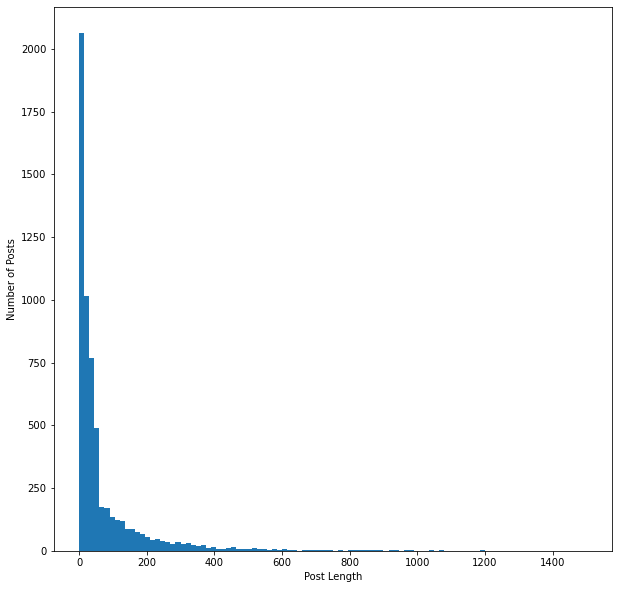

In [33]:
fig = plt.figure(figsize=(10,10))
plt.xlabel('Post Length')
plt.ylabel('Number of Posts')
plt.hist(post_lengths, bins=100, range=[0, 1500])
plt.show()

**Figuring out whether I want to remove very long/very short posts.** 

In [34]:
# zen_posts['selftext'].map(lambda x: len(x)).nlargest(10)

stoic_zen['tokens'].map(lambda x: len(x)).nlargest(10)

2733    6401
5558    2169
5254    1993
2824    1700
1025    1600
3868    1552
2715    1519
895     1438
5843    1423
2977    1406
Name: tokens, dtype: int64

In [35]:
stoic_zen['tokens'].map(lambda x: len(x)).nlargest(10)

2733    6401
5558    2169
5254    1993
2824    1700
1025    1600
3868    1552
2715    1519
895     1438
5843    1423
2977    1406
Name: tokens, dtype: int64

In [36]:
stoic_zen.iloc[2733]

label                                                                                                       0
merged     who are you?    the guide to finding your true identity by popular request, this post is a foll...
tokens    [who, are, you, the, guide, to, finding, your, true, identity, by, popular, request, this, post,...
Name: 2733, dtype: object

In [37]:
len(stoic_zen['tokens'][2733])

6401

_I am going to remove the above post as it is three times longer than the other posts and might distort the data training because all the words come from the same person and might add unnecessary redundancy that does not reflect the entire corpus._

In [38]:
stoic_zen.drop([2733], inplace=True)

In [39]:
# so what are the posts with the fewest words? 

stoic_zen['tokens'].map(lambda x: len(x)).nsmallest(20)

3358    0
5223    0
39      1
3157    1
3214    1
3222    1
3228    1
3271    1
3544    1
3552    1
3648    1
3823    1
3873    1
4168    1
4223    1
4752    1
4922    1
5056    1
5761    1
196     2
Name: tokens, dtype: int64

In [40]:
stoic_zen[ stoic_zen['merged'].str.len() <= 5 ]

,label,merged,tokens
39,0,das,[das]
3214,1,fact,[fact]
3271,1,yes,[yes]
3358,1,,[]
3648,1,np,[np]
4752,1,rest,[rest]
5223,1,(,[]


In [41]:
stoic_zen[ stoic_zen['merged'].str.len() <=10 ]

,label,merged,tokens
39,0,das,[das]
3157,1,stoicism,[stoicism]
3214,1,fact,[fact]
3222,1,epictetus,[epictetus]
3271,1,yes,[yes]
3293,1,x post,"[x, post]"
3358,1,,[]
3544,1,stoyc,[stoyc]
3552,1,church,[church]
3648,1,np,[np]


In [42]:
# dropping the very short rows but not the slightly longer ones 

# stoic_zen.drop(stoic_zen['merged'].str.len() <=20)

stoic_zen = stoic_zen[stoic_zen['merged'].str.len()>5]

In [43]:
stoic_zen[ stoic_zen['merged'].str.len() < 5 ]

,label,merged,tokens


In [44]:
#resetting index becuase of dropped rows 
stoic_zen.reset_index(drop=True, inplace=True)

In [45]:
# For future use, saving dataframe with tokenized column and with very long and very short posts dropped 

stoic_zen.to_csv('../datasets/clean_stoic_zen_tokenized.csv', index=False)

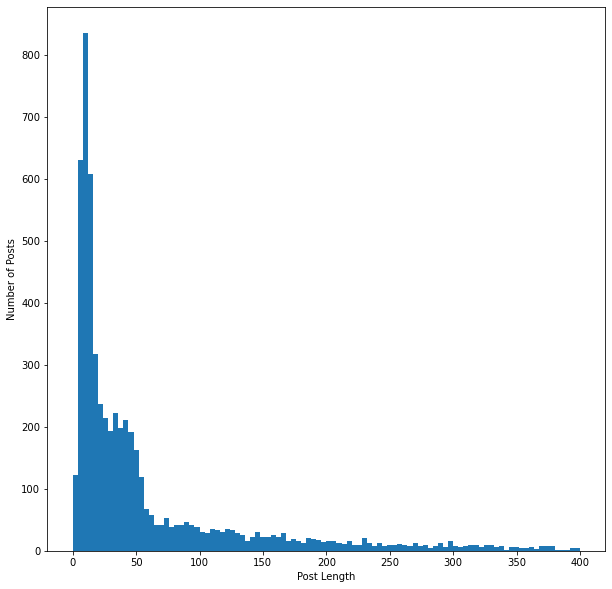

In [46]:
# re-running histogram without outlier

post_lengths = [len(tokens) for tokens in stoic_zen['tokens']]

fig = plt.figure(figsize=(10,10))
plt.xlabel('Post Length')
plt.ylabel('Number of Posts')
plt.hist(post_lengths, bins=100, range=[0, 400])
plt.show()

## Modeling

### `CountVectorizer` 

#### Vectorizing the data

In [47]:
# NB: turn this into a function 

In [48]:
X = stoic_zen['merged']
y = stoic_zen['label']

In [49]:
# always check value counts for a classification problem! 
y.value_counts(normalize=True)

0    0.500251
1    0.499749
Name: label, dtype: float64

In [50]:
# not scaling data right now 

In [51]:
# splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size=0.33,
                                                   shuffle=True,
                                                   stratify=y,
                                                   random_state=42)

In [52]:
cvec = CountVectorizer(stop_words='english')

cvec.fit(X_train)

X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [53]:
import sys
sys.getsizeof(X_train_cvec)

48

In [54]:
## VISUALIZE EMBEDDINGS HERE? 

#### Fitting the Classifier

In [55]:
lr = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', random_state=48)

lr.fit(X_train_cvec, y_train)

y_preds_cvec_lr = lr.predict(X_test_cvec)

#### Evaluation 

In [56]:
accuracy = accuracy_score(y_test, y_preds_cvec_lr)
accuracy

0.8699392712550608

In [57]:
lr.score(X_train_cvec, y_train)

0.9977561705310396

In [58]:
lr.score(X_test_cvec, y_test)

0.8699392712550608

**_VERY_ overfit**! 

`Confusion Matrix`

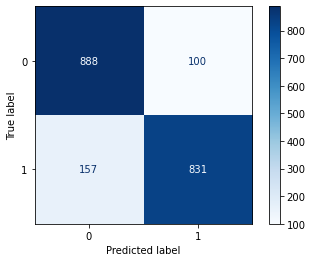

In [59]:
# confusion matrix 
tn, fp, fn, tp = confusion_matrix(y_test, y_preds_cvec_lr).ravel()

plot_confusion_matrix(lr, X_test_cvec, y_test, cmap="Blues", values_format='d');

In [60]:
# confusion matrix 
# cm = confusion_matrix(y_test, y_preds_cvec_lr)

# plot = plot_confusion_matrix(cm, classes=['Stoicism', 'Zen'])

In [79]:
range(lr.coef_.shape[0])

range(0, 1)

In [62]:
type(cvec.vocabulary_.items())

dict_items

In [77]:
lr.feature_

LogisticRegression(C=30.0, class_weight='balanced', random_state=48,
                   solver='newton-cg')

In [63]:
# cvec.vocabulary_.items()

In [78]:
def find_most_important_words(vectorizer, estimator, n=10):
    index_to_word = {v:k for k, v in vectorizer.vocabulary_.items()}
    
#     most_important = {}

    # get coefficient for each word in the vocabulary 
    word_importances = [(el, index_to_word[i]) for i, el in enumerate(np.exp(estimator.coef_[0]))]  
    
    # sort the word_imoprtance coefficients by the coefficient 
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)   

    # find words most important to label 1 by sorting by the highest coefficient
    closest_to_label_1 = sorted(sorted_coeff[:n], key = lambda x : x[0])
    
    # find words most important to label 0 by sorting by the smallest coefficient
    closest_to_label_0 = sorted_coeff[-n:]
    
    return closest_to_label_0, closest_to_label_1

In [80]:
find_most_important_words(cvec, lr, n=10)

([(0.028740370772306484, 'reasons'),
  (0.027132502870083824, 'forceful'),
  (0.02551160417676101, 'inspirational'),
  (0.024236488781546255, 'key'),
  (0.020515576109610734, 'awareness'),
  (0.016280540097385138, 'psychological'),
  (0.01547124693093144, 'worried'),
  (0.013244861321656032, 'inside'),
  (0.00829930259250194, 'ways'),
  (0.005573726487223559, 'emotion')],
 [(76.77890159962617, 'rely'),
  (79.91314019257027, 'post'),
  (80.76078456226223, 'tuesday'),
  (83.8496919001795, 'stoics'),
  (90.80763762290961, 'quote'),
  (312.8282539049779, 'stoic'),
  (471.62714449091095, 'ch'),
  (477.5857560876577, 'removed'),
  (504.616089178005, 'hadot'),
  (870.6925991387423, 'stoicism')])

In [101]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

def plot_most_important_words(scores_0, words_0, scores_1, words_1, title):
    
    y_pos = np.arange(len(words_1))
    
    pairs_1 = [(a,b) for a,b in zip(words_1, scores_1)]
    pairs_1 = sorted(pairs_1, key=lambda x: x[1])
    
    pairs_0 = [(a,b) for a,b in zip(words_0, scores_0)]
    pairs_0 = sorted(pairs_0, key=lambda x: x[1])
    
    words_1 = [a[0] for a in pairs_1]
    scores_1 = [a[1] for a in pairs_1]
    
    words_0 = [a[0] for a in pairs_0]
    scores_0 = [a[1] for a in pairs_0]
    
    fig = plt.figure(figsize=(8,8))
    
    plt.subplot(121)
    plt.barh(y_pos, scores_0, align='center', alpha=0.5)
    plt.title('Zen', fontdict=font)
    plt.yticks(y_pos, words_0, fontsize=14)
#     plt.suptitle('Key Words', fontsize=16)
    plt.xlabel('Importance', fontdict=font)
    
    plt.subplot(122)
    plt.barh(y_pos, scores_1, align='center', alpha=0.5)
    plt.title('Stoicism', fontdict=font)
    plt.yticks(y_pos, words_1, fontsize=14)
#     plt.suptitle('Key Words', fontsize=16)
    plt.xlabel('Importance', fontdict=font)
    
    plt.subplots_adjust(wspace=0.8)
 

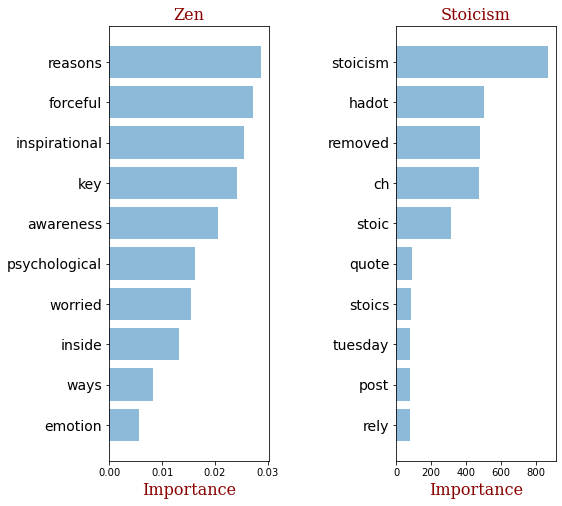

In [104]:
# getting most important words from get_important_words 

label_0_scores = [x[0] for x in closest_to_label_0]
label_0_words = [x[1] for x in closest_to_label_0]
label_1_scores = [x[0] for x in closest_to_label_1]
label_1_words = [x[1] for x in closest_to_label_1]

plot_most_important_words(label_0_scores, label_0_words, label_1_scores, label_1_words, 'title')

In [92]:
label_0_words

['reasons',
 'forceful',
 'inspirational',
 'key',
 'awareness',
 'psychological',
 'worried',
 'inside',
 'ways',
 'emotion']

In [93]:
label_1_scores

[76.77890159962617,
 79.91314019257027,
 80.76078456226223,
 83.8496919001795,
 90.80763762290961,
 312.8282539049779,
 471.62714449091095,
 477.5857560876577,
 504.616089178005,
 870.6925991387423]

In [84]:
closest_to_label_0, closest_to_label_1 = find_most_important_words(cvec, lr, n=10)

In [67]:
#trying to look at important features.... 
# for 0 / Zen 

# WHAT IS THIS DOING?? want to interpret 

# classes = {}
# for word in 

def find 

index_to_word = {v:k for k,v in cvec.vocabulary_.items()}

word_importances = [(el, index_to_word[i]) for i, el in enumerate(np.exp(lr.coef_[0]))] 

sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True) 

tops = sorted(sorted_coeff[:10], key = lambda x : x[0])

bottoms = sorted_coeff[-10:]

classes = {
    'tops':tops,
    'bottoms':bottoms
}

In [68]:
import numpy as np
np.exp(6.769288985900366)

870.6925991387423

In [69]:
tops

[(76.77890159962617, 'rely'),
 (79.91314019257027, 'post'),
 (80.76078456226223, 'tuesday'),
 (83.8496919001795, 'stoics'),
 (90.80763762290961, 'quote'),
 (312.8282539049779, 'stoic'),
 (471.62714449091095, 'ch'),
 (477.5857560876577, 'removed'),
 (504.616089178005, 'hadot'),
 (870.6925991387423, 'stoicism')]

In [70]:
bottoms

[(0.028740370772306484, 'reasons'),
 (0.027132502870083824, 'forceful'),
 (0.02551160417676101, 'inspirational'),
 (0.024236488781546255, 'key'),
 (0.020515576109610734, 'awareness'),
 (0.016280540097385138, 'psychological'),
 (0.01547124693093144, 'worried'),
 (0.013244861321656032, 'inside'),
 (0.00829930259250194, 'ways'),
 (0.005573726487223559, 'emotion')]

In [71]:
lr.coef_[0] # it's a dataframe so the [0] makes it an array I can use. These are the coefficients for each word in relation to stoicism..... 
# is this how close it is to be from class 1 ? to stoicism ???? 
# how do I explain/ know that these coefficients are associated with label 1 (ie stoicism)

array([ 2.49540307e-09,  7.34500573e-01,  2.24061338e-07, ...,
        8.55157465e-02, -7.78959401e-01,  5.02711519e-06])

In [65]:
type(lr.coef_[0])

numpy.ndarray

In [66]:
sorted_coeff[:10]

[(870.6925991387423, 'stoicism'),
 (504.616089178005, 'hadot'),
 (477.5857560876577, 'removed'),
 (471.62714449091095, 'ch'),
 (312.8282539049779, 'stoic'),
 (90.80763762290961, 'quote'),
 (83.8496919001795, 'stoics'),
 (80.76078456226223, 'tuesday'),
 (79.91314019257027, 'post'),
 (76.77890159962617, 'rely')]

In [72]:
# classes

1 is stoic, 0 is zen 

In [74]:
X_train.shape

(4011,)

In [75]:
X

0       you need to fight your mind every time it tries to convince you that you are  not good enough, c...
1       a phone call creates stronger bonds than text based communications  people too often choose to s...
2       everything in your life every experience, every relationship is a mirror of the mental pattern t...
3              the parable of the mexican fisherman got me reevaluating what it means to live my best life 
4       the key to success and productivity isn t to try to maximize every single minute in the day, but...
                                                       ...                                                 
5982    stoicism and self improvement i have just recently started practicing stoicism   currently readi...
5983    should i go cold turkey on entertainment to prove myself that i am not addicted to them? just st...
5984                                    free law of attraction, the secret pdf and books download  removed 
5985    anxiety i have troub

In [76]:
# word_importances

## TfidfVectorizer

In [68]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3)) 

tfidf.fit(X_train) 

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [69]:
lr_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', random_state=48)

lr_tfidf.fit(X_train_tfidf, y_train)

y_preds_tfidf_lr = lr_tfidf.predict(X_test_tfidf)

In [70]:
lr_tfidf.score(X_train_tfidf, y_train)

0.9985041136873598

In [71]:
lr_tfidf.score(X_test_tfidf, y_test)

0.8846153846153846

**_Slightly_ less overfit.**

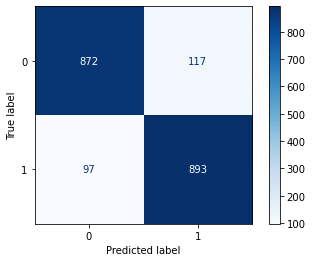

In [209]:
# tfidf confusion matrix 

tn, fp, fn, tp = confusion_matrix(y_test, y_preds_tfidf_lr).ravel()

plot_confusion_matrix(lr_tfidf, X_test_tfidf, y_test, cmap="Blues", values_format='d');

### `Tf-Idf Grid Search`

In [214]:
# tf-idf pipeline in two stages 

tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [221]:
pipe_params_tfidf = {
    'tfidf__max_features':[1000, 2000, 3000, 4000, 5000],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
    'tfidf__min_df': [0.5, 0.75, 1],
    'lr__C': [0.1, 1, 30.0],
    'lr__solver': ['newton-cg', 'lbfgs']
}

# (from above): 
# lr = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', random_state=48)


In [222]:
# gridsearch instantiation 

gs_tfidf_lr = GridSearchCV(tfidf_pipe,
                          pipe_params_tfidf,
                          cv = 5, 
                          verbose = 1,
                          n_jobs = 8)

In [223]:
gs_tfidf_lr.fit(X_train, y_train)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


/Users/emilynaftalin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.57409714        nan 0.57409714        nan 0.57409714        nan
        nan        nan        nan        nan        nan        nan
 0.85853051 0.87173101 0.86849315 0.87297634 0.86724782 0.87272727
 0.57409714        nan 0.57409714        nan 0.57409714        nan
        nan        nan        nan        nan        nan        nan
 0.85977584 0.87646326 0.86749689 0.87820672 0.86724782 0.87770859
 0.57409714        nan 0.57409714        nan 0.57409714        nan
        nan        nan        nan        nan        nan        nan
 0.85454545 0.87596513 0.86625156 0.88019925 0.86575342 0.88044832
 0.57409714        nan 0.57409714        nan 0.57409714        nan
        nan        nan        nan        nan        nan        nan
 0.85404732 0.87820672 0.86251557 0.87920299 0.86176837 0.87895392
 0.57409714        nan 0.57409714

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=8,
             param_grid={'lr__C': [0.1, 1, 30.0],
                         'lr__solver': ['newton-cg', 'lbfgs'],
                         'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
                         'tfidf__min_df': [0.5, 0.75, 1],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tfidf__stop_words': [None, 'english']},
             verbose=1)

In [224]:
gs_tfidf_lr.best_params_

{'lr__C': 1,
 'lr__solver': 'newton-cg',
 'tfidf__max_features': 5000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': None}

In [225]:
gs_tfidf_lr.best_score_

0.8933997509339975

In [226]:
gs_tfidf_lr.score(X_train, y_train)

0.936986301369863

In [227]:
gs_tfidf_lr.score(X_test, y_test)

0.8969176351692774

In [228]:
# predictions of tfidf logistic regression gridsearch 

gs_tfidf_preds = gs_tfidf_lr.predict(X_test)

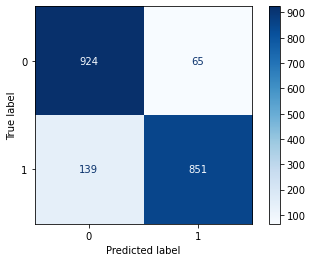

In [232]:

# confusion matrix 

tn, fp, fn, tp = confusion_matrix(y_test, gs_tfidf_preds).ravel()

plot_confusion_matrix(gs_tfidf_lr, X_test, y_test, cmap="Blues")

In [234]:
stoic_zen.iloc[100]

label                                                                                          0
merged                how to fight anxiety   the end of the most nebulous diseases of our times 
tokens    [how, to, fight, anxiety, the, end, of, the, most, nebulous, diseases, of, our, times]
Name: 100, dtype: object

In [240]:
stoic_zen.iloc[199]

label                                                                                                       0
merged    i m going to control what i can and i m not going to lose peace of mind over what i can t  relea...
tokens    [i, m, going, to, control, what, i, can, and, i, m, not, going, to, lose, peace, of, mind, over,...
Name: 199, dtype: object